In [1]:
import ast
import numpy as np

import pandas as pd
import datetime

df = pd.read_csv("../metadata/merged_metadata.csv")
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)))
df['published_date'] = df['published_date'].apply(
    lambda x: datetime.datetime.fromtimestamp(int(x)))
df['film_year'] = df['film_date'].apply(lambda it: it.year)
df['published_year'] = df['published_date'].apply(lambda it: it.year)

# Filter dataset
print(
    f"Total talks between 2010-2016: {len(df.loc[(df['film_year'] >= 2010) & (df['film_year'] <= 2016), :])}")

# We will use videos between 2010-2016
df = df.loc[(df['film_year'] >= 2010) & (df['film_year'] <= 2016), :]
# Num_speakers == 1
df = df.loc[df['num_speaker'] == 1, :]

# Replace nan occupation with ""
df['speaker_occupation']: pd.Series = df['speaker_occupation'].fillna("")

Total talks between 2010-2016: 1738


# Views target set

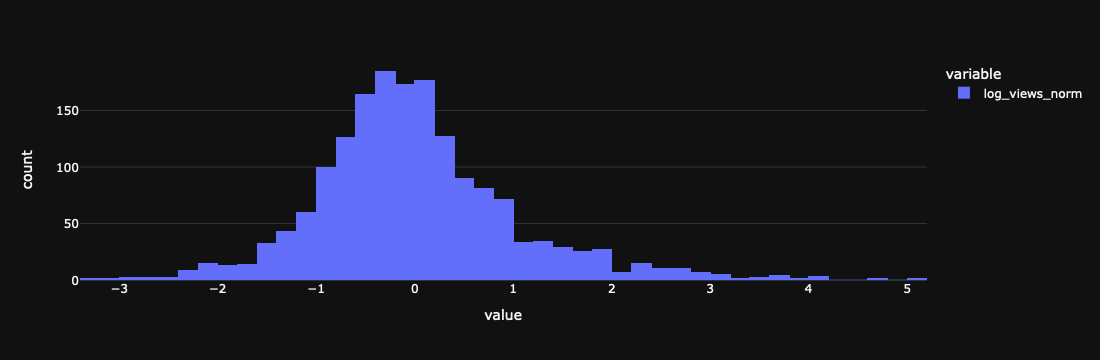

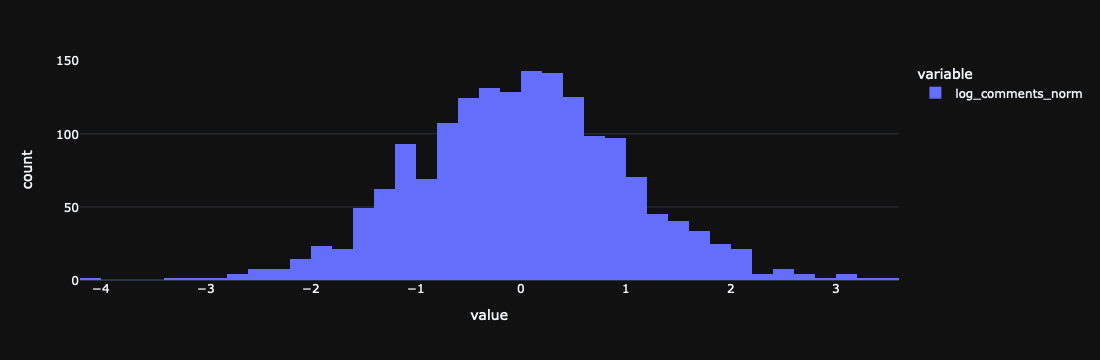

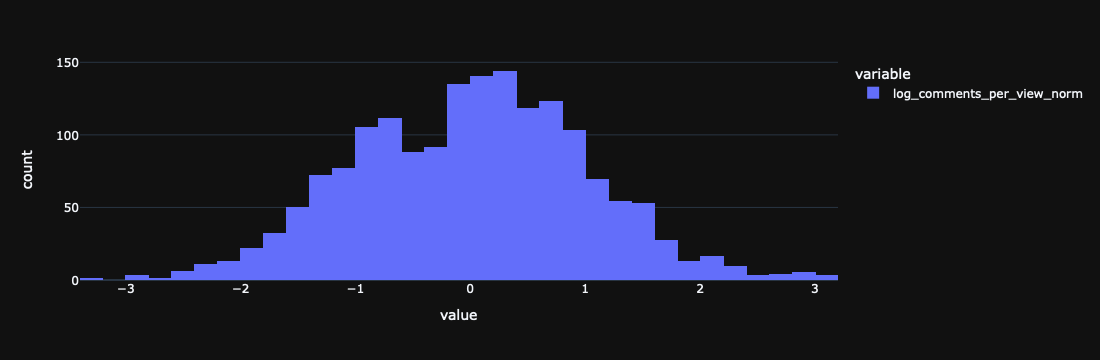

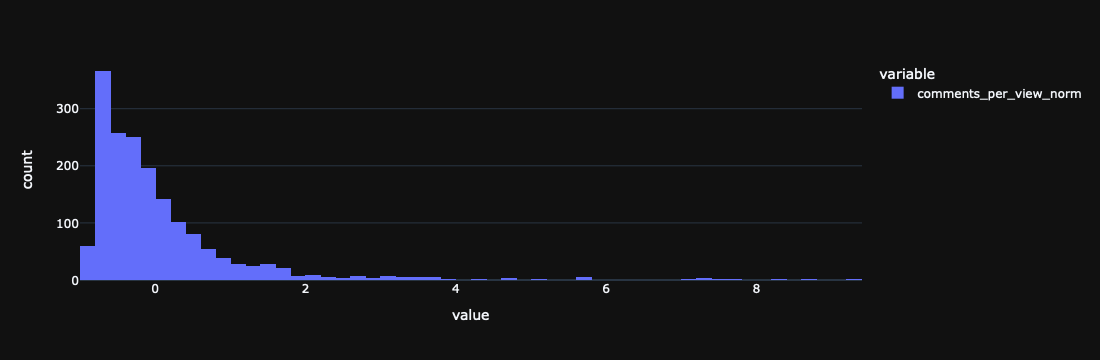

In [56]:
import plotly.express as px
    
log_views = np.log(df['views'])
df['log_views_norm'] = (log_views - log_views.mean()) / log_views.std()
px.histogram(df['log_views_norm']).show()

log_comments = np.log(df['comments'])
df['log_comments_norm'] = (log_comments - log_comments.mean()) / log_comments.std()
px.histogram(df['log_comments_norm']).show()

comments_per_view = df['comments'] / df['views']
log_comments_per_view = np.log(comments_per_view)
df['log_comments_per_view_norm'] = (log_comments_per_view - log_comments_per_view.mean()) / log_comments_per_view.std()
px.histogram(df['log_comments_per_view_norm']).show()

df['comments_per_view_norm'] = (comments_per_view - comments_per_view.mean()) / comments_per_view.std()
px.histogram(df['comments_per_view_norm']).show()

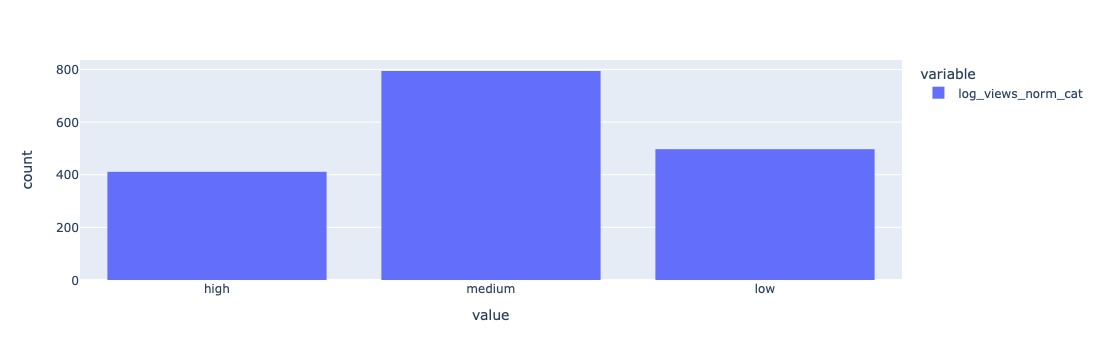

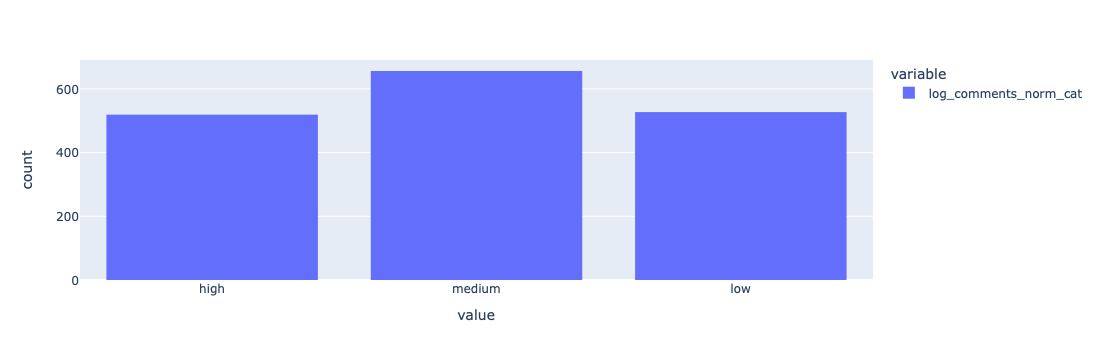

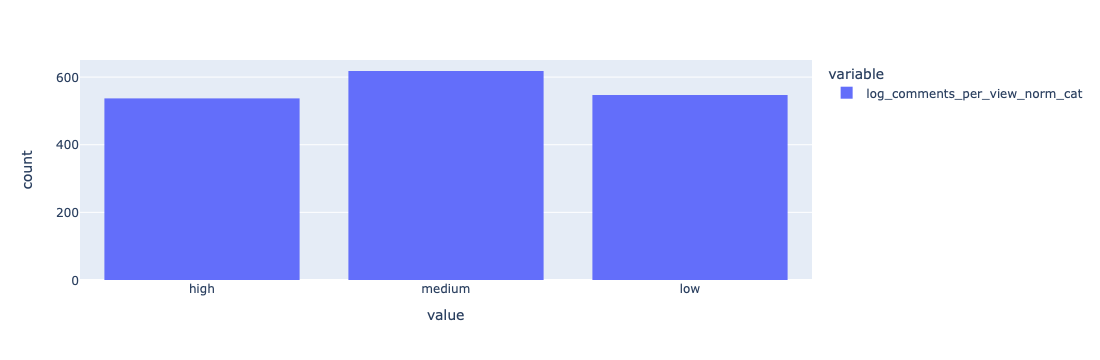

In [47]:
from functools import partial

def map_to_label(value, ranges, labels):
    if len(ranges) != len(labels):
        raise ValueError("Number of labels must be equal to the number of ranges")

    for range, label in zip(ranges, labels):
        if value >= range[0] and value <= range[1]:
            return label

    raise ValueError(f"value {value} not located between ranges: {ranges}")

views_mapping_5 = partial(map_to_label,
                          ranges=[[-np.inf, -1.5], [-1.5, -0.5], [-0.5, 0.5], [0.5, 1.5], [1.5, np.inf]],
                          labels=["very_low", "low", "medium", "high", "very_high"])

views_mapping_3 = partial(map_to_label,
                          ranges=[[-np.inf, -0.5], [-0.5, 0.5], [0.5, np.inf]],
                          labels=["low", "medium", "high"])

comments_mapping_3 = partial(map_to_label,
                          ranges=[[-np.inf, -0.5], [-0.5, 0.5], [0.5, np.inf]],
                          labels=["low", "medium", "high"])



df['log_views_norm_cat'] = df['log_views_norm'].apply(views_mapping_3)
df['log_comments_norm_cat'] = df['log_comments_norm'].apply(views_mapping_3)
df['log_comments_per_view_norm_cat'] = df['log_comments_per_view_norm'].apply(comments_mapping_3)

px.histogram(df['log_views_norm_cat']).show()
px.histogram(df['log_comments_norm_cat']).show()
px.histogram(df['log_comments_per_view_norm_cat']).show()

In [8]:
def calculate_sentiment(ratings: list) -> float:
    """
    Returns a value from -1, 1 indicating negative/positive sentiment, by counting the positive and negative tags

    :param ratings: Ratings related to video ([{'name': 'Funny', 'count': 100}, {'name': 'Beautiful', 'count':10}, ...})
    :return: The sentiment
    """
    positive_ratings = {'Courageous', 'Beautiful', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring',
                     'Jaw-dropping', 'Persuasive'}
    negative_ratings = {'Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing'}

    positive_count = np.sum([tag['count'] for tag in ratings if tag['name'] in positive_ratings])
    negative_count = np.sum([tag['count'] for tag in ratings if tag['name'] in negative_ratings])

    return (positive_count - negative_count) / (positive_count + negative_count)


df['sentiment'] = df['ratings'].apply(ast.literal_eval).apply(calculate_sentiment)

"[{'id': 21, 'name': 'Unconvincing', 'count': 181}, {'id': 8, 'name': 'Informative', 'count': 962}, {'id': 9, 'name': 'Ingenious', 'count': 263}, {'id': 10, 'name': 'Inspiring', 'count': 795}, {'id': 23, 'name': 'Jaw-dropping', 'count': 141}, {'id': 24, 'name': 'Persuasive', 'count': 728}, {'id': 25, 'name': 'OK', 'count': 221}, {'id': 22, 'name': 'Fascinating', 'count': 367}, {'id': 3, 'name': 'Courageous', 'count': 224}, {'id': 1, 'name': 'Beautiful', 'count': 39}, {'id': 11, 'name': 'Longwinded', 'count': 80}, {'id': 7, 'name': 'Funny', 'count': 38}, {'id': 2, 'name': 'Confusing', 'count': 61}, {'id': 26, 'name': 'Obnoxious', 'count': 78}]"

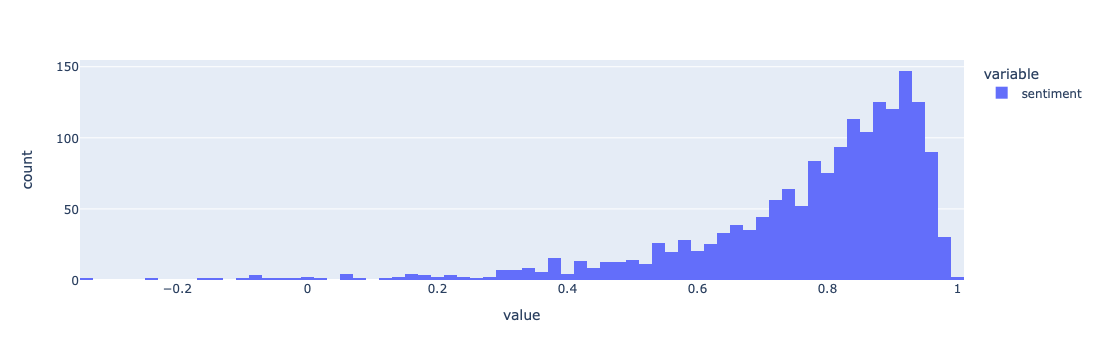

In [33]:
px.histogram(df['sentiment']).show()

In [77]:
positive_ratings = {'Courageous', 'Beautiful', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring',
                 'Jaw-dropping', 'Persuasive'}
negative_ratings = {'Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing'}
    
def normalize_rating(ratings, name):
    rating_count = [t['count'] for t in ast.literal_eval(ratings) if t['name'] == name][0]
    return rating_count / np.sum([t['count'] for t in ast.literal_eval(ratings)])

df['rating'] = df['ratings'].apply(lambda ratings: normalize_rating(ratings, 'Funny'))
    
df['log_rating'] = np.log(df['rating']+ 0.001)
df['log_rating_norm'] = (df['log_rating'] - df['log_rating'].mean()) / df['log_rating'].std()
px.histogram(df['log_rating_norm'])


In [72]:
counts = {'positive': 0, 'negative': 0}
for idx, row in df.iterrows():
    ratings = ast.literal_eval(row['ratings'])
    sorted_ratings = sorted(ratings, key=lambda it: it['count'], reverse=True)
    if 'Fascinating' in [rat['name'] for rat in sorted_ratings[:5]]:
        counts['positive'] += 1
    else:
        counts['negative'] += 1

In [73]:
counts

{'positive': 937, 'negative': 217}

In [43]:
sorted_counts = counts
px.bar(x=list(counts.keys()), y=list(counts.values()))

In [97]:
# All ratings
# Total negative

negative_ratings = {'Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing'}

negative_count = []
for idx, row in df.iterrows():
    ratings = ast.literal_eval(row['ratings'])
    neg_sum = 0
    for rat in ratings:
        if rat['name'] in negative_ratings:
            neg_sum += rat['count']
    negative_count.append(neg_sum)

log_neg = np.log(np.array(negative_count)+0.001)
px.histogram((log_neg - log_neg.mean())/ log_neg.std())
    

1153
